In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from scipy.stats import beta

In [2]:
df_stats = pd.read_csv('Data/Seasons_Stats.csv')

In [3]:
def set_plot_params(size):
    plt.rcParams["figure.figsize"] = [16,9]
    SIZE = size
    plt.rc('font', size=14)  
    plt.rc('axes', titlesize=14)  
    plt.rc('axes', labelsize=14)  
    plt.rc('xtick', labelsize=14)  
    plt.rc('ytick', labelsize=14)
    plt.rc('legend', fontsize=12)  
    plt.rc('figure', titlesize=SIZE)

In [4]:
def remove_duplicate_players(data_frame):
    """Removes duplicate rows of players which played for multiple teams during the season"""
    # Input should be just one season data
    
    player_occurrences = {}
    for i in range(len(data_frame)):
        player_name = data_frame.iloc[i]['Player']
        player_team = data_frame.iloc[i]['Tm']
        index_row = data_frame.index[i]
        if player_name not in player_occurrences:
            player_occurrences[player_name] = []
        player_occurrences[player_name].append((player_team, index_row))

    for key in player_occurrences:
        curr_list = player_occurrences[key]
        if len(curr_list) == 1:
            continue
        for team, index in curr_list:
            if team != "TOT":
                data_frame = data_frame.drop(index)
    return data_frame

In [5]:
def organize_data(season):
    df = pd.read_csv('Data/Seasons_Stats.csv') 
    df = df[df['Year'] == season]
    df = remove_duplicate_players(df)
    df = df[['Player', '3P', '3PA', '3P%']]
    df = df[df['3PA'] > 20]
    a = beta.fit(list(df['3P%']),floc=0, fscale=1)[0]
    b =  beta.fit(list(df['3P%']),floc=0, fscale=1)[1]
    df['3PEstimate'] = (df['3P'] + a) / (df['3PA'] + a + b)
    df['a'] = df['3P'] + a
    df['b'] = df['3PA'] - df['3P'] + b
    print('alpha: {:.2}'.format(a))
    print('beta: {:.2}'.format(b))
    return (df, a, b)

In [6]:
def make_plots(df, a, b):
    plt.rcParams["figure.figsize"] = [10,6]
    
    plt.figure()
    plt.hist(df['3P%'], bins=30)
    plt.xlabel('3PT %')
    plt.ylabel('Number of Players')
    plt.title('Distribution of 3PT%')
    plt.savefig('plots/3PT%.png')
    
    plt.figure()
    x = np.linspace(0.01, 0.99, 100)
    y = beta.pdf(x, a, b)
    plt.hist(df['3P%'], bins=30, normed=True, label='Emperical')
    plt.plot(x, y, 'k-', lw=2, label='Beta')
    plt.xlabel('3PT %')
    plt.ylabel('Number of Players')
    plt.title('Beta Approximation of 3PT%')
    plt.legend()
    plt.xlim(0.1, 0.7)
    plt.savefig('plots/betaapprox.png')

    plt.figure()
    plt.hist(df['3P%'], bins=30, normed=True, label='Emperical', alpha=0.6)
    plt.hist(df['3PEstimate'], bins =12, alpha=0.6, label='Estimate', normed=True)
    plt.xlabel('3PT %')
    plt.ylabel('Number of Players')
    plt.title('Bayesian Estimation of 3PT%')
    plt.legend()
    plt.savefig('plots/estimation.png')
    
    plt.figure()
    y1 = beta.pdf(x, a, b)
    plt.plot(x, y1, 'r--', lw=1, alpha=0.6, label='League\nDistribution')

    # Plot the top player
    df_top = df.sort_values(by='3PEstimate', ascending=False).iloc[0]
    y2 = beta.pdf(x, df_top['a'], df_top['b'])
    print('Top alpha and beta: {:.2}, {:.2}'.format(df_top['a'], df_top['b']))
    plt.plot(x, y2, 'b-', lw=1, alpha=0.6, label='Top Player')
    interval_top = beta.interval(.95, df_top['a'], df_top['b'])
    plt.fill_between(x, 0, y2, where= (x>interval_top[0]) & (x<interval_top[1]), alpha=0.6)

    # Plot the bottom player
    df_bottom = df.sort_values(by='3PEstimate', ascending=False).iloc[-1]
    y3 = beta.pdf(x, df_bottom['a'], df_bottom['b'])
    print('Bottom alpha and beta: {:.2}, {:.2}'.format(df_bottom['a'], df_bottom['b']))
    plt.plot(x, y3, 'g-', lw=1, alpha=0.6, label='Bottom Player')
    interval_bottom = beta.interval(.95, df_bottom['a'], df_bottom['b'])
    plt.fill_between(x, 0, y3, where= (x>interval_bottom[0]) & (x<interval_bottom[1]), alpha=0.6)
    
    top_plr = df_top['Player']
    bottom_plr = df_bottom['Player']
    
    plt.xlim(0.1, 0.7)
    plt.xlabel('3PT %')
    plt.ylabel('3PT% Estimate')
    plt.title('Best: {0}(actual %: {1})\nWorst: {2}(actual %: {3})\nBayesian 3-Point% Estimation'
              .format(top_plr, df_top['3P%'], bottom_plr, df_bottom['3P%']))
    plt.legend()
    plt.savefig('plots/best_player_estimation.png')


alpha: 2.3e+01
beta: 4.4e+01
Top alpha and beta: 2.2e+02, 2.7e+02
Bottom alpha and beta: 2.8e+01, 7.6e+01


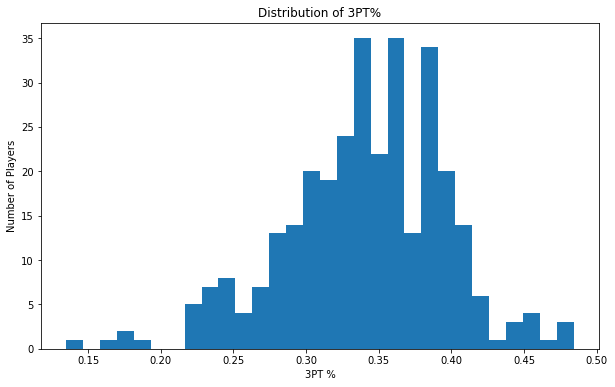

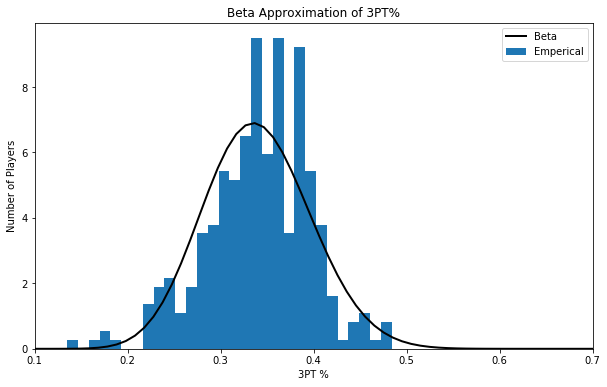

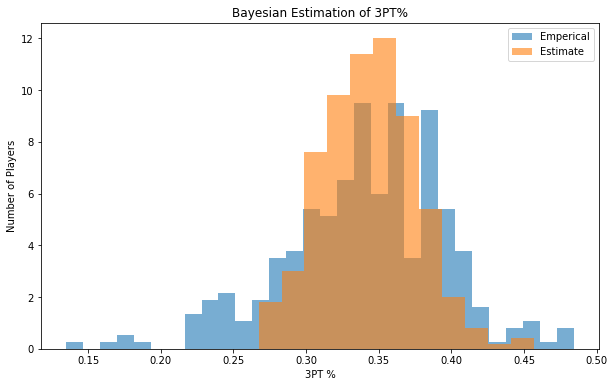

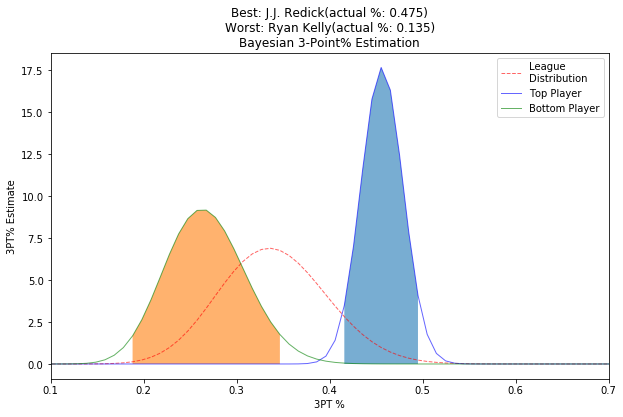

In [7]:
#set_plot_params(36)
df, a, b = organize_data(2016)
make_plots(df, a, b)